In [44]:
# Loading libraries for the course
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
from matplotlib import animation            # Module to plot animations
from skimage import filters, measure, segmentation, color
from scipy.ndimage import gaussian_filter
from skimage.filters import difference_of_gaussians
import pandas as pd
from cellpose import models
from scipy import ndimage as ndi

In [45]:
# Loading data

figName = '../Drug9_1000nM/rep1_FOV1.tif'
img = imread(str(figName))

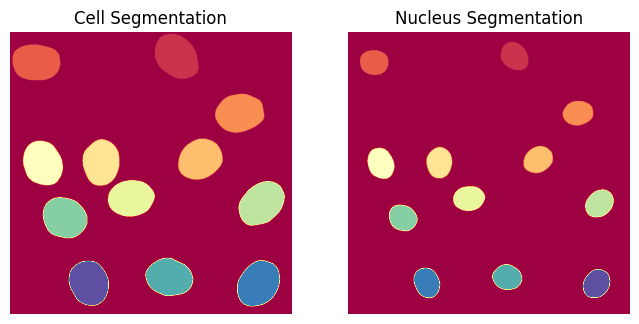

Values in mask:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [46]:
from cellpose import models, plot

img_cyto_max = np.max(img[:, :, :, 1], axis = 0)
model1 = models.Cellpose(gpu = False, model_type = 'cyto')

# Apply the model to your image
masks_cyto, flows, styles, diams = model1.eval(img_cyto_max, diameter=None, channels=[0,0])
# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(masks_cyto,cmap='Spectral')
ax[0].axis('off')
ax[0].set_title('Cell Segmentation')

img_nuc = img[0, :, :, 0]
model2 = models.Cellpose(gpu = False, model_type = 'cyto')

# Apply the model to your image
masks_nuc, flows, styles, diams = model2.eval(img_nuc, diameter=50, channels=[0,0])
# Plotting each one of the 3 colors independently
ax[1].imshow(masks_nuc,cmap='Spectral')
ax[1].axis('off')
ax[1].set_title('Nucleus Segmentation')
plt.show()
print('Values in mask: ', np.unique (masks_nuc))

In [47]:
# Make sure that one cell has the same id in both masks
# Get the unique labels in the cell and nucleus masks
cell_labels = np.unique(masks_cyto)
nucleus_labels = np.unique(masks_nuc)

# Initialize the mapping table
mapping_table = {}

# Loop through each cell label
for cell_label in cell_labels:
    # Skip the background
    if cell_label == 0:
        continue

    # Get the mask for the current cell
    current_cell_mask = (masks_cyto == cell_label)

    # Loop through each nucleus label
    for nucleus_label in nucleus_labels:
        # Skip the background
        if nucleus_label == 0:
            continue

        # Get the mask for the current nucleus
        current_nucleus_mask = (masks_nuc == nucleus_label)

        # If the current cell and the current nucleus overlap, add them to the mapping table
        if np.any(current_cell_mask & current_nucleus_mask):
            mapping_table[cell_label] = nucleus_label
            break
updated_masks_nuc = masks_nuc.copy()

# Loop through each item in the mapping table
for cell_label, nucleus_label in mapping_table.items():
    # Update the nucleus label in the nucleus mask
    updated_masks_nuc[masks_nuc == nucleus_label] = cell_label
masks_nuc = updated_masks_nuc

## identify live cells through nucleus signal

In [48]:
# live cell number
t_total = img.shape[0]
th_nuc = 80
df_cells_alive = pd.DataFrame(index = ['number of live cells', 'live cell id'], dtype=object)
nucleus_labels = np.unique(masks_nuc)

for t in range(t_total):
    num_t = 0
    list_cells_alive = []
    image = img[t, :, :, 0]
    for id in nucleus_labels:
        if id == 0:
            continue  # Skip background
          
        cell_mask = (masks_nuc == id)
        
        # Calculate the mean intensity of the current cell
        total_intensity = np.sum(image * cell_mask)
        area = np.sum(cell_mask)
        mean_intensity = total_intensity / area if area > 0 else 0

        if mean_intensity > th_nuc:
           num_t += 1
           list_cells_alive.append(id)
        # Append the results to the list
    df_cells_alive.loc['number of live cells', 'frame'+str(t+1)] = int(num_t)
    df_cells_alive['frame'+str(t+1)] = df_cells_alive['frame'+str(t+1)].astype('object')
    df_cells_alive.at['live cell id', 'frame'+str(t+1)] = list_cells_alive

df_cells_alive

,frame1,frame2,frame3,frame4,frame5,frame6,frame7,frame8,frame9,frame10,...,frame12,frame13,frame14,frame15,frame16,frame17,frame18,frame19,frame20,frame21
number of live cells,12.0,12.0,12.0,12.0,12.0,9.0,8.0,8.0,8.0,7.0,...,6.0,6.0,6.0,6.0,6.0,5.0,5.0,5.0,5.0,5.0
live cell id,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 3, 4, 5, 6, 7, 9, 11, 12]","[1, 3, 4, 6, 7, 9, 11, 12]","[1, 3, 4, 6, 7, 9, 11, 12]","[1, 3, 4, 6, 7, 9, 11, 12]","[1, 3, 6, 7, 9, 11, 12]",...,"[1, 3, 6, 7, 9, 11]","[1, 3, 6, 7, 9, 11]","[1, 3, 6, 7, 9, 11]","[1, 3, 6, 7, 9, 11]","[1, 3, 6, 7, 9, 11]","[1, 3, 7, 9, 11]","[1, 3, 7, 9, 11]","[1, 3, 7, 9, 11]","[1, 3, 7, 9, 11]","[1, 3, 7, 9, 11]"


## calculate the number of mRNAs in each nuclei and cytoplasm

In [49]:
# mRNA identification
threshold_m = 0.025
cell_id = np.unique(masks_cyto)
t_total = img.shape[0]

df_m_c = pd.DataFrame()
df_m_n = pd.DataFrame()

df_m_c['cell id'] = cell_id[1:]
df_m_n['cell id'] = cell_id[1:]


# get the area of a single mRNA
mRNA = img[0, :, :, 2]
mRNA_filtered = difference_of_gaussians(mRNA, low_sigma=1, high_sigma=5)

mRNA_binary = mRNA_filtered.copy()
mRNA_binary[mRNA_binary>=threshold_m] = threshold_m # Making spots above the threshold equal to the threshold value.
mRNA_binary[mRNA_binary<threshold_m] = 0 # Making spots below the threshold equal to 0.

mRNA_binary[mRNA_binary!=0] = 1 # Binarization

# spot_contours = measure.find_contours(mRNA_binary, 0.9) # only used for figure generation

labels_m = measure.label(mRNA_binary)

props = measure.regionprops(labels_m, intensity_image=mRNA)

# Initialize a list to store the intensities
areas = []

# Loop through each mRNA in the image
for prop in props:
    # Calculate the intensity of the current mRNA and add it to the list
    areas.append(prop.area)

areas = np.array(areas)
areas_sorted = np.sort(areas)
start = np.percentile(areas_sorted, 10)
end = np.percentile(areas_sorted, 50)
selected_areas = areas_sorted[(areas_sorted>=start) & (areas_sorted<=end)]
single_mRNA_area = np.mean(selected_areas)

for t in range(t_total):
    mRNA = img[t, :, :, 2]
    mRNA_filtered = difference_of_gaussians(mRNA, low_sigma=1, high_sigma=5)

    mRNA_binary = mRNA_filtered.copy()
    mRNA_binary[mRNA_binary>=threshold_m] = threshold_m # Making spots above the threshold equal to the threshold value.
    mRNA_binary[mRNA_binary<threshold_m] = 0 # Making spots below the threshold equal to 0.

    mRNA_binary[mRNA_binary!=0] = 1 # Binarization

    # spot_contours = measure.find_contours(mRNA_binary, 0.9) # only used for figure generation

    labels_m = measure.label(mRNA_binary)
    mRNA_num_cyto = []
    mRNA_num_nuc = []

    for id in cell_id:
        # Skip the background
        if id == 0:
            continue

        # Get the mask for the current cell
        nuc_mask = (masks_nuc == id)

        # Calculate the properties of the mRNAs in the current cell
        props_n = measure.regionprops(labels_m * nuc_mask, intensity_image = mRNA)
        if props_n == []:
            mRNA_num_nuc.append(0)
        else:
            # Initialize the total area, total intensity and count for the current cell
            total_area_n = 0
            count_n = 0

            # Loop through each mRNA in the current cell
            for prop in props_n:
                # Update the total area, total intensity and count
                total_area_n += prop.area

            count_n = round(total_area_n / single_mRNA_area)
            # Add the results for the current cell to the DataFrame

            mRNA_num_nuc.append(count_n)
        
        # Get the mask for the current cell
        mask_c = (masks_cyto == id)
        mask_n = (masks_nuc == id)
        cyto_mask = mask_c & ~mask_n

        # Calculate the properties of the mRNAs in the current cell
        props_c = measure.regionprops(labels_m * cyto_mask, intensity_image = mRNA)

        if props_c == []:
            mRNA_num_cyto.append(0)
        else:  
            # Initialize the total area, total intensity and count for the current cell
            total_area_c = 0
            count_c = 0

            # Loop through each mRNA in the current cell
            for prop in props_c:
                # Update the total intensity and count
                total_area_c += prop.area

            count_c = round(total_area_c / single_mRNA_area)
            # Add the results for the current cell to the DataFrame

            mRNA_num_cyto.append(count_c)

    df_m_c['frame' + str(t+1)] = mRNA_num_cyto
    df_m_n['frame' + str(t+1)] = mRNA_num_nuc


In [50]:
# Save the DataFrame to a csv file
df_m_n.to_csv('mRNAs_in_nucleus.csv', index=False)
df_m_c.to_csv('mRNAs_in_cyto.csv', index=False)

## number and intensity of transcription site in each cell

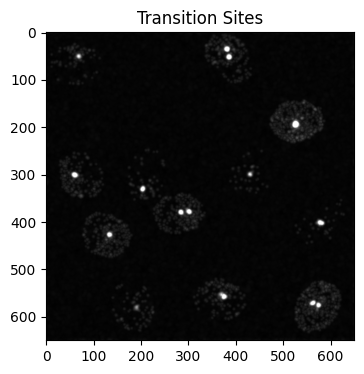

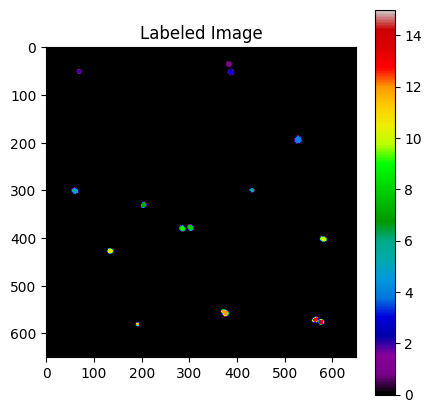

In [51]:
trans_site = np.max(img[:, :, :, 2], axis=0)

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(trans_site, cmap='gray')
plt.title('Transition Sites')
plt.show()

# Apply a threshold to segment the transition sites
threshold = filters.threshold_otsu(trans_site)
binary_trans = trans_site > threshold

# Label connected components
labeled_trans, num_labels = ndi.label(binary_trans)

plt.figure(figsize=(5,5))
plt.imshow(labeled_trans, cmap='nipy_spectral')
plt.colorbar()
plt.title('Labeled Image')
plt.show()

In [52]:
# Initialize an empty DataFrame
df_trans = pd.DataFrame()

# Initialize an empty list to store the cell each region belongs to
cell_labels = []

# Loop over each frame in the image
for i in range(img.shape[0]):
    # Calculate the properties of each region for the current frame
    regions = measure.regionprops(labeled_trans, intensity_image=img[i,:,:,2])
    
    # Get the mean intensity of each region
    brightness = [(region.mean_intensity)*(region.area) for region in regions]
    
    # Add the brightness values to the DataFrame
    df_trans['frame'+str(i+1)] = brightness

# Loop over each region
for region in regions:
    # Get the coordinates of the region
    coords = region.coords
    
    # Get the labels of the cells that the region belongs to in masks_cyto
    labels = masks_cyto[coords[:,0], coords[:,1]]
    
    # Get the most common label, which is the cell that the region belongs to
    cell_label = np.argmax(np.bincount(labels))
    
    # Add the cell label to the list
    cell_labels.append(cell_label)

# Add the cell labels to the DataFrame
df_trans.insert(0, 'cell', cell_labels)

df_trans

,cell,frame1,frame2,frame3,frame4,frame5,frame6,frame7,frame8,frame9,...,frame12,frame13,frame14,frame15,frame16,frame17,frame18,frame19,frame20,frame21
0,1,3855.0,3822.0,3903.0,3667.0,3910.0,3608.0,9209.0,6216.0,3593.0,...,6465.0,10463.0,6484.0,5819.0,4658.0,4329.0,4420.0,27364.0,16295.0,8388.0
1,2,5140.0,4000.0,13465.0,5779.0,2648.0,2287.0,2277.0,2131.0,2409.0,...,2109.0,2168.0,2111.0,2369.0,2301.0,2154.0,2004.0,2155.0,2224.0,1968.0
2,1,3934.0,3880.0,3845.0,3947.0,3486.0,3394.0,4036.0,3722.0,3356.0,...,5553.0,6815.0,5674.0,3817.0,3568.0,26861.0,14626.0,8943.0,7335.0,4665.0
3,3,30193.0,41349.0,34842.0,18123.0,22810.0,21571.0,12321.0,13035.0,8138.0,...,41082.0,39456.0,19057.0,29499.0,17006.0,9010.0,6690.0,6036.0,28532.0,15568.0
4,6,5128.0,4939.0,12793.0,5865.0,4766.0,4694.0,4267.0,28898.0,11257.0,...,14881.0,7809.0,5984.0,5918.0,5316.0,3790.0,4000.0,4038.0,3668.0,4228.0
5,4,1868.0,3339.0,2010.0,1881.0,2099.0,1744.0,3026.0,10354.0,10974.0,...,1998.0,2025.0,2131.0,1881.0,1958.0,1816.0,1904.0,1942.0,1924.0,1913.0
6,5,3093.0,3287.0,3258.0,22205.0,10547.0,5473.0,3312.0,3224.0,3138.0,...,3276.0,3265.0,3275.0,2722.0,2997.0,3147.0,3235.0,3240.0,2928.0,3399.0
7,7,4625.0,3744.0,3568.0,3359.0,4690.0,3938.0,3647.0,3985.0,3406.0,...,5976.0,4525.0,23598.0,14554.0,8054.0,4322.0,3248.0,7138.0,3691.0,7099.0
8,7,3255.0,3356.0,3026.0,6043.0,8540.0,4865.0,3749.0,4609.0,3346.0,...,4142.0,3599.0,5356.0,4453.0,5142.0,3597.0,12467.0,8329.0,4218.0,23268.0
9,8,3966.0,19707.0,10494.0,8423.0,23447.0,4551.0,3738.0,3803.0,4295.0,...,3841.0,3729.0,4034.0,3898.0,4551.0,3792.0,3907.0,4056.0,3869.0,4051.0


In [53]:
# Count the number of transcription sites for each cell
transcription_sites_per_cell = df_trans['cell'].value_counts()
for i in cell_id[1:]:
    if i not in transcription_sites_per_cell.index:
        transcription_sites_per_cell[i] = 0
sorted_trans = transcription_sites_per_cell.sort_index()
num_trans = sorted_trans.tolist()

In [54]:
# Save the DataFrame to a csv file
df_trans.to_csv('trans.csv', index=False)

## Cell size, nucleus size and number of transcription sites

In [55]:
cell_size = []
nucleus_size = []
trans_num = []

cell_id = np.unique(masks_cyto)
nucleus_id = np.unique(masks_nuc)

for id in cell_id:
    if id == 0:
        continue
    cell_size.append(np.sum(masks_cyto == id))

for id in nucleus_id:
    if id == 0:
        continue
    nucleus_size.append(np.sum(masks_nuc == id))

df_info = pd.DataFrame({
    'cell_id': cell_id[1:],
    'cell_size': cell_size,
    'nucleus_size': nucleus_size,
    'trans_num': num_trans,
})
df_info

,cell_id,cell_size,nucleus_size,trans_num
0,1,8006,3227,2
1,2,7493,3021,1
2,3,7819,3127,1
3,4,7428,3232,1
4,5,7075,3318,1
5,6,7363,3420,1
6,7,6976,3235,2
7,8,7959,3168,1
8,9,7508,3068,1
9,10,7241,3050,1


In [56]:
df_info.to_csv('Basic_Information.csv', index=False)

## Protein Intensity

In [57]:
#Protein Intensity
#createDataFrame
df_protein = pd.DataFrame()

# t_total = img.shape[0]

for t in range(t_total):
     # If the frame has multiple channels, use only the first channel
    frame = img[t, :, :, 1]
    df_protein['cell id'] = np.nan
    df_protein['frame'+str(t+1)] = np.nan
    # Get unique cell masks
    unique_masks = np.unique(masks_cyto)
    
    # Loop through each unique mask (cell)
    for cell_id in unique_masks:
        if cell_id == 0:
            continue  # Skip background
        
        # Create a mask for the current cell
        cell_mask = (masks_cyto == cell_id).astype(np.uint8)
        
        # Check the sizes of the frame and cell_mask
        if frame.shape != cell_mask.shape:
            print(f"Size mismatch: frame shape {frame.shape}, cell_mask shape {cell_mask.shape}")
            continue
        
        # Calculate the mean intensity of the current cell
        total_intensity = np.sum(frame * cell_mask)
        area = np.sum(cell_mask)
        mean_intensity = total_intensity / area if area > 0 else 0
        
        # Append the results to the list
        df_protein.loc[cell_id-1, 'cell id'] = int(cell_id)
        df_protein.loc[cell_id-1, 'frame'+str(t+1)] = mean_intensity

# Save the DataFrame
df_protein.to_csv('protein_intensity.csv', index=False)